# Laplace's Equation in a Circle

Variational Form:

$$
A(v, u) = - \int_\Omega \nabla v \cdot \nabla u \, dx, \quad F(v; f) = \int_\Omega v f \, dx
$$

Where 

$$
\Omega = \left\{x \in \mathbb{R}^2 : \left|\left|x\right|\right| \leq 1\right\}
$$

Example: let 

$$
f(x) = 1 - ||x||^2
$$



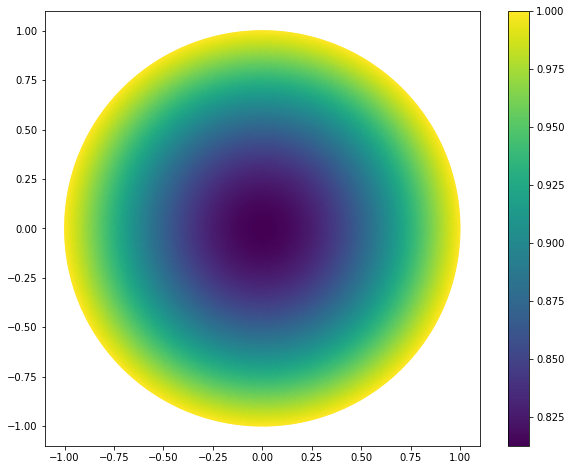

In [29]:
# imports 
from fenics import *
from mshr import *   # meshing utility
import matplotlib.pyplot as plt    # plotting

Ω = Circle(Point(0, 0), 1.0)

N = 100   # N is like 1 / Δx
mesh = generate_mesh(Ω, N)

V = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)

bc = DirichletBC(V, Constant(1.0), "on_boundary")

f_expr = Expression("1 - pow(x[0], 2) - pow(x[1], 2)", degree=1)
f = project(f_expr, V)  # have to evaluate on function space

# variational form
A = -dot(grad(v), grad(u)) * dx
F = v * f * dx

# solve
u_sol = Function(V)
solve(A == F, u_sol, bc)

plt.figure(figsize=(10, 8))
fig = plot(u_sol, mode="color")
plt.colorbar(fig)

plt.show()

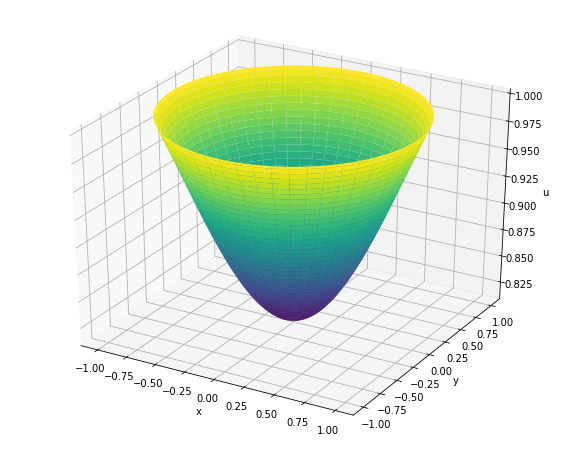

In [30]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

θ = np.linspace(0, 2*np.pi, 100)
r = np.linspace(0, 1, 100)
Θ, R = np.meshgrid(θ, r)

X, Y = R * np.cos(Θ), R * np.sin(Θ)
U = np.zeros(np.shape(R))
u_sol.set_allow_extrapolation(True)
[m, n] = np.shape(U)
for i in range(m):
    for j in range(n):
        x, y = X[i, j], Y[i, j]
        U[i, j] = u_sol(x, y)
        
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, U,cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.savefig("fenics-laplace-circle.pdf")
plt.show()

# Heat Equation in a Circle (Crank-Nicolson)

Variational Form:

$$
A_{n+1}(v, u; \Delta t) = \int_\Omega \left(v u_{n+1} + \frac{\Delta t}{2} \nabla v \cdot \nabla u_{n+1} 
\right) \, dx
$$

$$
F_n(v, u; \Delta t) = \int_\Omega \left(v u_n - \frac{\Delta t}{2} \nabla v \cdot \nabla u_n \right) \, dx
$$

$$
\Omega = \left\{x \in \mathbb{R}^2 : ||x|| \leq 1\right\}
$$

Example:

$$
u(x, t=0) = u_0(x) = 1 - ||x||^2, \quad t \in \left[0, T\right], \quad 
\Delta t = \frac{T}{N}
$$

In [4]:
# time stepping
T = 1
N = 50
Δt = T / N

# initial condition
u_n = Function(V, name="solution")
u_n.assign(Constant(3.0))

# variational problem
A = (v * u + 0.5 * Δt * dot(grad(v), grad(u)) ) * dx
F = (v * u_n - 0.5 * Δt * dot(grad(v), grad(u_n)) ) * dx


u_next = Function(V)

# saving to file
xdmfname = "heat-sol.xdmf"
fout = XDMFFile(xdmfname)
fout.parameters["flush_output"] = True
fout.parameters["functions_share_mesh"] = True
fout.parameters["rewrite_function_mesh"] = False

# solution
for n in range(N):
    solve(A == F, u_next, bc)
    u_n.assign(u_next)
    fout.write(u_n, n * Δt)

# Catenary

$$
\min_{u, \lambda} F(u; \lambda) = \int_{-1}^1 u \sqrt{1 + (\epsilon u')^2} \, dx - 
\lambda \int_{-1}^1 \left[\frac{\ell}{2} - \sqrt{1 + (\epsilon u')^2} \right] \, dx
$$

$$
\frac{ds}{dx} = \sqrt{1 + (\epsilon u')^2} \implies F(u; \lambda) = \int_{-1}^1 u(x) \frac{ds}{dx}(x) - 
\lambda \left[\frac{\ell}{2} - \frac{ds}{dx}(x) \right] \, dx
$$

2.597033699203166e-12


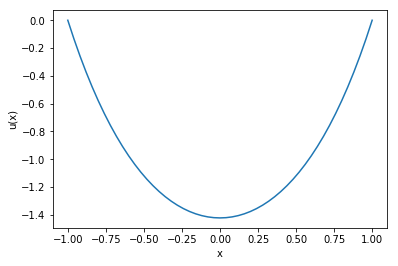

In [31]:
# parameters
ℓ = Constant(3)
ϵ = Constant(0.5)

# mesh
N = 50
mesh = IntervalMesh(N, -1, 1)

# build function space for F
u_fe = FiniteElement("CG", mesh.ufl_cell(), 1)   # space for u
λ_fe = FiniteElement("R", mesh.ufl_cell(), 0)   # λ in R
V = FunctionSpace(mesh, MixedElement([u_fe, λ_fe]))  # C[-1, 1] x R

# get my functional
f = Function(V)

# split up u and λ
u, λ = split(f)

# build the functional
dsdx = sqrt(1 + (ϵ * u.dx(0)**2))   # x**2 = x^2

# constraint
constraint = (ℓ / Constant(2) - dsdx)
F = (u * dsdx - λ * constraint) * dx
# total derivative
dF = derivative(F, f)
# second derivative
d2F = derivative(dF, f)


# boundary condition
bc = DirichletBC(V.sub(0), Constant(0), "on_boundary")    # 0'th subspace of V is C[-1, 1]


# initial guess
init_val = 1.0
f.interpolate(Expression(("amp*(x[0]+1)*(x[0]-1)","0"),degree=2,amp=init_val))

# build the nonlinear problem
problem = NonlinearVariationalProblem(dF, f, bc, d2F)

# build a solver
solver = NonlinearVariationalSolver(problem)
solver.parameters['nonlinear_solver'] = 'snes'
solver.parameters['snes_solver']['line_search'] = 'bt'
solver.parameters['snes_solver']['maximum_iterations'] = 1000

# solve
solver.solve()

# verify the solution satisfies the constraint:
print(assemble(dsdx * dx) - float(ℓ))

# plot result
plot(u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()

## Laplace's Equation in a complicated Geometry

Let $\Omega$ be a rectangle $\left[a, b\right] \times \left[c, d\right]$, with a circle centered at the origin with radius 1 removed.  Let $S_c$ be the boundary of the circle, and $S_r$ be the outer boundary of the rectangle.  We wish to solve the following problem

$$
\nabla^2 u = 0, \quad x \in \Omega, \quad \left.\frac{\partial u}{\partial n}\right|_{x\in S_r} = 0, 
\quad \left. u\right|_{x\in S_c} = f(x)
$$

Variational form, trial function $v$ such that $v = 0$ for all $ x \in S_c$.

$$
\int_\Omega v \nabla^2 u \, dx = \int_{\partial \Omega} v \frac{\partial u}{\partial n} \, d\sigma - 
\int_\Omega \nabla v \cdot \nabla u \, dx = 
\int_{S_r} v (0) \, d\sigma - \int_\Omega \nabla v \cdot \nabla u \, dx = 
-\int_\Omega \nabla v \cdot \nabla u \, dx = A
$$

$$
\int_\Omega v\nabla^2 u \, dx = \int_\Omega v (0) \, dx = 0
$$

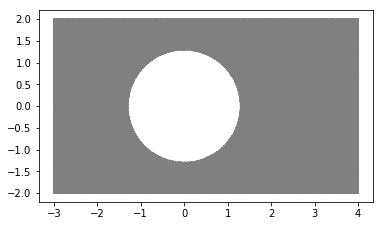

In [79]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

TOL = 1e-3
a = -3
b = 4
c = -2
d = 2

R = 1.3

N = 100

Ω = Rectangle(Point(a, c), Point(b, d)) - Circle(Point(0, 0), R)
mesh = generate_mesh(Ω, N)

plot(mesh)
plt.show()

f = Expression("sin(x[0])", degree=2)

def circle_boundary(x, on_boundary):
    normx = sqrt(pow(x[0], 2) + pow(x[1], 2))
    return normx <= 1.5 and on_boundary

In [87]:
class Piecewise(UserExpression):
    def __init__(self, a, b, c, d, tol):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.tol = tol
        super().__init__()
    
    def eval(self, values, x):
        if abs(x[1] - self.d) < tol or abs(x[1] - self.c) < tol:
            values[0] = 0
        else:
            values[0] = (cos(self.a) * (self.b - x[0]) - cos(self.b) * (x[0] - self.a)) / (self.b - self.a)
    def value_shape(self):
        return ()
    
h = Piecewise(a, b, c, d, TOL)

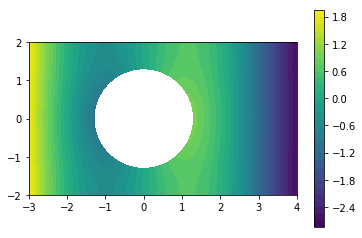

In [89]:
V = FunctionSpace(mesh, "CG", 1)
f_proj = project(f, V)
g = -div(grad(f_proj))

u = TrialFunction(V)
v = TestFunction(V)

A = -dot(grad(v), grad(u)) * dx
F = v * g * dx + v * h * ds

bc = DirichletBC(V, Constant(0.0), circle_boundary)

u_sol = Function(V)

solve(A==F, u_sol, bc)

true_sol = u_sol + f_proj
fig = plot(true_sol)
plt.colorbar(fig)
plt.show()

## Heat Equation with Phase Change in cylinder

$$
\tilde \Omega = \{\tilde x \in \mathbb{R}^3 : \tilde x = (r\cos\theta, r\sin\theta, z), 
0 \leq r < R, 0 < z < H, 0 \leq \theta \leq 2\pi\}
$$

Let $S_2$ be the top surface ($z = H$), and $S_1 = \partial \tilde \Omega \setminus S_2$

$$
\frac{\partial \tilde T}{\partial \tilde t} = \tilde \nabla \cdot \left(
\tilde \kappa(\tilde T) \tilde \nabla \tilde T\right), \quad \tilde x \in \tilde \Omega, \quad 
\tilde T(\tilde x, 0) = T_c, \quad \tilde T = T_H, \quad \tilde x \in S_1, \quad 
\frac{\partial \tilde T}{\partial \tilde n} = 0, \quad \tilde x \in S_2
$$

With a heat conductivity dependent on temperature:

$$
\tilde\kappa (\tilde T) = \kappa_0 + \left(\frac{\kappa_1 - \kappa_0}{2}\right) \left[
1 + \tanh\left(\frac{\tilde T - T_*}{\mu}\right)\right]
$$

Nondimensionalize:

$$
u = \frac{\tilde T - T_H}{T_c - T_H}, \quad \kappa(u) = \frac{\tilde \kappa(\tilde T(u))}{\kappa_0} = 
1 - \frac{1 - k}{2}\left[1 - \tanh\left(\frac{u - \tau}{\eta}\right)\right]
$$

$$
k = \frac{\kappa_1}{\kappa_0}, \quad \tau = \frac{T_H - T_*}{T_H - T_c}. \quad 
\eta = \frac{\mu}{T_H - T_c}
$$

$$
\tilde x = R x, \quad \tilde t = \frac{R^2}{\kappa_0} t
$$

$$
\Omega = \{x \in \mathbb{R}^3 : x = (r\cos\theta, r\sin\theta, z), 0 \leq r < 1, \quad 
0 < z < h\}, \quad h = \frac{H}{R}
$$

$$
\frac{\partial u}{\partial t} = \nabla \cdot \left(\kappa(u) \nabla u\right), \quad x \in \Omega, \quad 
u(x, 0) = 1, \quad u = 0, \quad x \in S_1, \quad \frac{\partial u}{\partial n} = 0, \quad x \in S_2
$$

Controlling parameters:

$$
h, k (< 1), \tau (< 1), \eta
$$

FEniCS implementation

Crank-Nicolson time discritization:

$$
\frac{\partial u}{\partial t} = F(u) \implies \frac{u_{n+1} - u_n}{\Delta t} = \frac{1}{2} \left(
F(u_{n+1}) + F(u_n)\right)
$$

$$
u_{n+1} - \frac{\Delta t}{2} F(u_{n+1}) = u_n + \frac{\Delta t}{2} F(u_n)
$$

Variational form:

$$
\left\langle u_{n+1}, v\right\rangle - \frac{\Delta t}{2} \left\langle F(u_{n+1}), v\right\rangle = 
\left\langle u_n, v\right\rangle + \frac{\Delta t}{2} \left\langle F(u_n), v\right\rangle, \quad 
\left\langle u, v\right\rangle = \int_\Omega u v \, dx
$$

$$
\left\langle F(u), v\right\rangle = \int_\Omega v \nabla \cdot \left(\kappa (u) \nabla u\right) \, dx = 
\int_{\partial \Omega} v \kappa (u) \frac{\partial u}{\partial n} \, ds - 
\int_\Omega \kappa (u) \nabla v \cdot \nabla u \, dx
$$

Since $v = 0$ on $S_1$ (the Dirichlet boundary), and $\frac{\partial u}{\partial n} = 0$ on $S_2$ (the 
Neumann boundary), then the boundary term vanishes giving

$$
\left\langle F(u), v\right\rangle = -\int_\Omega \kappa(u) \nabla v \cdot \nabla u \, dx =: 
\left\langle \kappa (u) \nabla u, \nabla v\right\rangle
$$

With the Crank-Nicolson time discretization, this gives 

$$
\left\langle u_{n+1}, v\right\rangle + \frac{\Delta t}{2} \left\langle \kappa (u_{n+1}) \nabla u_{n+1}, 
\nabla v\right\rangle = \left\langle u_n, v\right\rangle - \frac{\Delta t}{2} \left\langle 
\kappa(u_n) \nabla u_n, \nabla v\right\rangle
$$

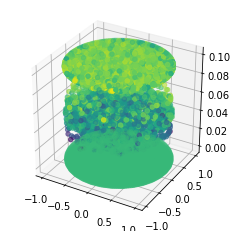

In [48]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from fenics import *
from mshr import *
from ufl import tanh

# tolerance value for boundaries
tol = 1e-10

# parameters
h = 0.1   # ratio of height to radius
k = 0.5   # ratio of cooked heat diffusivity to raw diffusivity
τ = 0.6   # (T_H - T*) / (T_H - T_c)
η = 3.0   # rate of cooking at temperature



# convert parameters to function like
h = Constant(h)
k = Constant(k)
τ = Constant(τ)
η = Constant(η)

# def tanh(X):
#     num = exp(X) - exp(-X)
#     den = exp(X) + exp(-X)
#     return num / den 

# build heat capacity from temperature
def κ(u):
    κ_val = 1 - (1 - k) / 2 * (1 - tanh((u - τ) / η))
    return κ_val

# time discretization
Tmax = 0.5
Nt = 30
Δt = Constant(Tmax / Nt)

# domain
R = 1.0
N = 50
Ω = Cylinder(Point(0, 0, h), Point(0, 0, 0), R, R)
mesh = generate_mesh(Ω, N)

# function space
V = FunctionSpace(mesh, "CG", 1)

# boundary condition
def dirichlet_boundary(x, on_boundary):
    on_side = abs(pow(x[0], 2) + pow(x[1], 2) - pow(R, 2)) < tol and on_boundary
    on_bottom = abs(x[2]) < tol and on_boundary
    return on_side or on_bottom

bc = DirichletBC(V, Constant(0.0), dirichlet_boundary)
    
# variational form
u_prev = Function(V, name="solution")

#κ = Expression("1 - (1 - k) / 2 * (1 - tanh(u - T) / n)", degree=2, k=k, T=τ, n=η, u=u_prev)


#u = TrialFunction(V)
u = Function(V)
v = TestFunction(V)

L = (u_prev * v) * dx - Constant(0.5) * Δt * κ(u_prev) * dot(grad(u_prev), grad(v)) * dx
A = (u * v) * dx + Constant(0.5) * Δt * κ(u) * dot(grad(u), grad(v)) * dx
F = A - L


# initial condition
u_init = interpolate(Constant(1.0), V)
u_prev.assign(u_init)

t = np.linspace(0, Tmax, Nt+1)
u_sols = []
u_sols.append(u_prev)

# filename for storing solution
xdmfname = "heat-nonlin-sol.xdmf"
fout = XDMFFile(xdmfname)
fout.parameters["flush_output"] = True
fout.parameters["functions_share_mesh"] = True
fout.parameters["rewrite_function_mesh"] = False

# time stepping
for n in range(Nt):
    #u_next = Function(V)
    solve(F==0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})
    u_prev.assign(u)
    u_sols.append(u_prev)
    fout.write(u_prev, t[n])
    #κ.u = u_prev
    
plot(u_sols[-1])
plt.show()

